In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
file_path = 'rates.csv'

The `data` dataframe will only be used when initially loading the CSV file

In [3]:
data = pd.read_csv(file_path, header=None)

In [4]:
data

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,181
0,Date,1Y01Y,Date,1Y02Y,Date,1Y03Y,Date,1Y05Y,Date,1Y10Y,...,Date,FY03Y,Date,FY05Y,Date,FY10Y,Date,FY20Y,Date,FY30Y
1,09-Nov-11,1.31,24-Nov-11,0.972,24-Nov-11,1.207,24-Nov-11,1.701,24-Nov-11,2.336,...,24-Nov-11,1.04,24-Nov-11,1.52,24-Nov-11,2.22,24-Nov-11,2.56,24-Nov-11,2.62
2,10-Nov-11,0.72,25-Nov-11,0.996,25-Nov-11,1.25,25-Nov-11,1.76,25-Nov-11,2.408,...,25-Nov-11,1.07,25-Nov-11,1.57,25-Nov-11,2.29,25-Nov-11,2.64,25-Nov-11,2.69
3,11-Nov-11,0.78,28-Nov-11,0.989,28-Nov-11,1.243,28-Nov-11,1.76,28-Nov-11,2.421,...,28-Nov-11,1.06,28-Nov-11,1.56,28-Nov-11,2.3,28-Nov-11,2.64,28-Nov-11,2.69
4,14-Nov-11,0.75,29-Nov-11,0.965,29-Nov-11,1.215,29-Nov-11,1.745,29-Nov-11,2.429,...,29-Nov-11,1.03,29-Nov-11,1.54,29-Nov-11,2.3,29-Nov-11,2.66,29-Nov-11,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,30-Jun-23,4.502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3039,03-Jul-23,4.586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3040,04-Jul-23,4.586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3041,05-Jul-23,4.568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The array `fwds` will contain the labels for each of the series of fwd rates, any `nan`s at the end of the CSV file are filtered out of it

In [20]:
fwds = data.iloc[0, :].unique()
fwds = fwds[np.array([isinstance(item, str) for item in fwds])][1:]

The working dataframe will be called `df` and starts as an empty dataframe.  

We iterate through the fwds array getting each `label` and use an index `i` to move across the `data` dataframe.
At each iteration;
1. create a new dataframe _imaginatively_ called `s` which contains each series of dates and forwards
2. we drop any `nan` values from the dates
3. we convert the dates from strings to datetime objects
4. make the date column the index of `s`
5. rename the column of fwds with `label`
6. values of `'00/01/1900'` are artifacts from Excel, and are replaced by `nan`
7. the column containing the forward rate (`s[label]`) is re-cast as a float
8. concatenate to the `df` dataframe

In [21]:
df = pd.DataFrame()
i = 0
for label in fwds:
    s = data.iloc[1:, i:i+2]
    s = s.dropna(subset=[i])
    s[i] = pd.to_datetime(s[i], format=('%d-%b-%y'))
    s = s.set_index(s.columns[0])
    s = s.rename(columns={i+1: label})
    s[label] = s[label].replace('00/01/1900', np.nan)
    s[label] = s[label].astype(float)
    df = pd.concat([df,s],axis=1)
    i += 2

In [22]:
exp_mapping = {
    'A':'1M',
    'C':'3M',
    'F':'6M',
    'J':'9M',   # not sure about this, is it 1Y?
    'O':'15M',  # not sure about this, is it 18M, 5Y?
    'T':'10Y',
    'Z':'30Y',
}

def remap(fwd):
    exp, tenor, _ = fwd.split('Y')
    exp = exp_mapping[exp] if exp in exp_mapping else exp + 'Y'
    return f'{exp}{int(tenor)}Y'

remapped_fwds = {f: remap(f) for f in fwds}

df = df.rename(columns=remapped_fwds)

,1Y1Y,1Y2Y,1Y3Y,1Y5Y,1Y10Y,1Y20Y,1Y30Y,2Y1Y,2Y2Y,2Y3Y,...,3M10Y,3M20Y,3M30Y,6M1Y,6M2Y,6M3Y,6M5Y,6M10Y,6M20Y,6M30Y
2011-11-09,1.310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-10,0.720,NaN,NaN,NaN,NaN,NaN,NaN,1.050,1.410,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-11,0.780,NaN,NaN,NaN,NaN,NaN,NaN,0.980,1.370,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-14,0.750,NaN,NaN,NaN,NaN,NaN,NaN,1.110,1.450,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-15,0.750,NaN,NaN,NaN,NaN,NaN,NaN,1.100,1.440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,4.502,4.130,3.920,3.713,3.608,3.606,3.343,3.744,3.614,3.543,...,3.786,3.720,3.447,5.205,4.609,4.281,3.945,3.722,3.680,3.410
2023-07-03,4.586,4.216,3.999,3.770,3.647,3.637,3.365,3.829,3.686,3.602,...,3.827,3.752,3.470,5.267,4.690,4.360,4.006,3.763,3.712,3.433
2023-07-04,4.586,4.216,3.999,3.770,3.647,3.637,3.365,3.829,3.686,3.602,...,3.827,3.752,3.470,5.267,4.690,4.360,4.006,3.763,3.712,3.433
2023-07-05,4.568,4.216,4.006,3.795,3.681,3.668,3.395,3.850,3.710,3.634,...,3.855,3.780,3.498,5.233,4.674,4.355,4.022,3.794,3.741,3.462


Make sure that the dates are ordered.

`ffill` then forward fills any missing values with the value from the previous date
`bfill` fills in any holes at the start, though it might be better to use `dropna` in this case

In [8]:
df = df.sort_index(ascending=True)
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

Let's use `matplotlib` to plot one of the forward rates
* `xticks` allows us to rotates the tick labels on the `x` axis
* `grid` does what it says on the tin
* `xlabel` and `ylabel` add labels to the respective axes
* the semi-colon at the end hides text output from `plt`

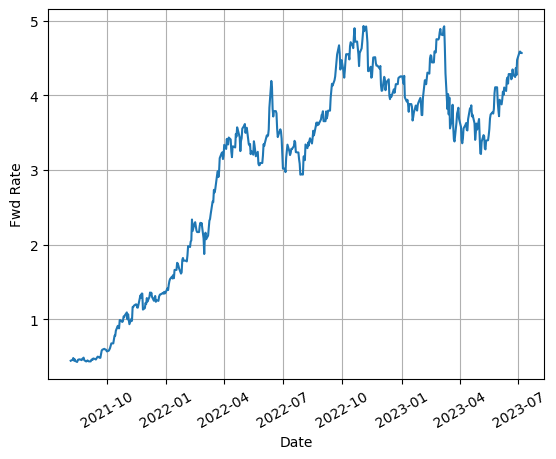

In [10]:
plt.plot(df['1Y01Y'][-500:])
plt.xticks(rotation=30)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Fwd Rate');